In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from ls.config.loader import load_config
import IPython.display as ipd
import torch

In [3]:
# --- 1. load config ---
cfg = load_config("../configs/config.yaml")

print("Dataset config:", cfg.dataset)
print("Audio config:", cfg.audio)

Dataset config: {'name': 'icbhi', 'data_folder': '/Users/gkont/Downloads/Datasets/icbhi_dataset', 'cycle_metadata_path': '/Users/gkont/Downloads/Datasets/icbhi_dataset/icbhi_metadata.csv', 'class_split': 'lungsound', 'split_strategy': 'official', 'test_fold': 0, 'multi_label': True, 'n_cls': 4, 'weighted_sampler': True, 'batch_size': 16, 'num_workers': 0, 'h': 128, 'w': 1024}
Audio config: {'sample_rate': 16000, 'desired_length': 10.0, 'remove_dc': True, 'normalize': False, 'pad_type': 'repeat', 'use_fade': True, 'fade_samples_ratio': 64, 'n_mels': 128, 'frame_length': 40, 'frame_shift': 10, 'low_freq': 100, 'high_freq': 5000, 'window_type': 'hanning', 'use_energy': False, 'dither': 0.0, 'mel_norm': 'mit', 'resz': 1.0, 'raw_augment': 1, 'wave_aug': [{'type': 'Crop', 'sampling_rate': 16000, 'zone': [0.0, 1.0], 'coverage': 1.0, 'p': 0.0}, {'type': 'Noise', 'color': 'white', 'p': 0.1}, {'type': 'Speed', 'factor': [0.9, 1.1], 'p': 0.1}, {'type': 'Loudness', 'factor': [0.5, 2.0], 'p': 0.1},

## Test DataLoaders

### ICBHI Dataloader using only test set as the validation set

In [4]:
# Regular training
from ls.data.dataloaders import build_dataloaders

train_loader, test_loader = build_dataloaders(cfg.dataset, cfg.audio)

[Transforms] Input spectrogram resize factor: 1.0, target size: (128, 1024)
[Transforms] Input spectrogram resize factor: 1.0, target size: (128, 1024)
[ICBHI] Loaded cycle metadata TSV: 6898 rows
[ICBHI] #Sites=7, #Devices=4


/opt/homebrew/Caskroom/miniconda/base/envs/icbhi-ast/lib/python3.11/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


[ICBHI] Extracted 4142 cycles from 539 recordings
[ICBHI] Metadata join missing: 0 (strict join; should be 0)
[ICBHI] Input spectrogram shape: (997, 128, 1)
[ICBHI] 4142 cycles
  Class 0: 2063 (49.8%)
  Class 1: 1215 (29.3%)
  Class 2: 501 (12.1%)
  Class 3: 363 (8.8%)
[ICBHI] Loaded cycle metadata TSV: 6898 rows
[ICBHI] #Sites=7, #Devices=4


/opt/homebrew/Caskroom/miniconda/base/envs/icbhi-ast/lib/python3.11/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


[ICBHI] Extracted 2756 cycles from 381 recordings
[ICBHI] Metadata join missing: 0 (strict join; should be 0)
[ICBHI] Input spectrogram shape: (997, 128, 1)
[ICBHI] 2756 cycles
  Class 0: 1579 (57.3%)
  Class 1: 649 (23.5%)
  Class 2: 385 (14.0%)
  Class 3: 143 (5.2%)


In [6]:
for batch in train_loader:
    print(batch["input_values"].shape, batch["label"].shape, batch["filename"])
    break

torch.Size([16, 1, 128, 1024]) torch.Size([16, 2]) ['158_1p3_Lr_mc_AKGC417L', '166_1p1_Ll_sc_Meditron', '107_3p2_Ar_mc_AKGC417L', '138_2p2_Pr_mc_AKGC417L', '156_5b3_Lr_mc_AKGC417L', '166_1p1_Ll_sc_Meditron', '158_1p3_Pr_mc_AKGC417L', '156_2b3_Pr_mc_AKGC417L', '192_2b1_Al_mc_LittC2SE', '114_1b4_Lr_mc_AKGC417L', '166_1p1_Pl_sc_Meditron', '191_2b1_Pl_mc_LittC2SE', '130_3p2_Tc_mc_AKGC417L', '158_1p2_Ll_mc_AKGC417L', '107_3p2_Ar_mc_AKGC417L', '158_1p3_Tc_mc_AKGC417L']


/opt/homebrew/Caskroom/miniconda/base/envs/icbhi-ast/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [7]:
from collections import Counter
import numpy as np

def inspect_batch_balance(train_loader, n_batches=100):
    pattern_counter = Counter()
    total = 0
    for i, batch in enumerate(train_loader):
        labels = batch["label"].cpu().numpy()
        # For multi-label mode (2 columns)
        if labels.ndim == 2:
            patterns = [tuple(v) for v in labels]
        else:
            patterns = [int(v) for v in labels]
        pattern_counter.update(patterns)
        total += len(patterns)
        if i >= n_batches:
            break

    print(f"\nChecked {total} samples from {n_batches} batches")
    for pat, c in sorted(pattern_counter.items()):
        print(f"Pattern {pat}: {c} ({100*c/total:.1f}%)")

In [8]:
inspect_batch_balance(train_loader, n_batches=100)


Checked 1616 samples from 100 batches
Pattern (np.float32(0.0), np.float32(0.0)): 396 (24.5%)
Pattern (np.float32(0.0), np.float32(1.0)): 356 (22.0%)
Pattern (np.float32(1.0), np.float32(0.0)): 472 (29.2%)
Pattern (np.float32(1.0), np.float32(1.0)): 392 (24.3%)


In [9]:
def tensors_equal(a, b, atol=1e-6, rtol=1e-5):
    return torch.allclose(a, b, atol=atol, rtol=rtol)

Inspecting sample index 8 in the batch
Keys: dict_keys(['input_values', 'audio', 'filename', 'cycle_index', 'pid', 'duration', 'start_time', 'end_time', 'site', 'device', 'site_id', 'device_id', 'age', 'bmi', 'label'])
Filename: 192_2b1_Al_mc_LittC2SE
Cycle index: tensor(3)
Label: tensor([0., 1.])
Duration: tensor(2.7420, dtype=torch.float64)
Start-End: tensor(6.9790, dtype=torch.float64) - tensor(9.7210, dtype=torch.float64)
Crackle/Wheeze: tensor(0.) tensor(1.)
Waveform shape: torch.Size([1, 160000])
Mel image shape: torch.Size([1, 128, 1024])


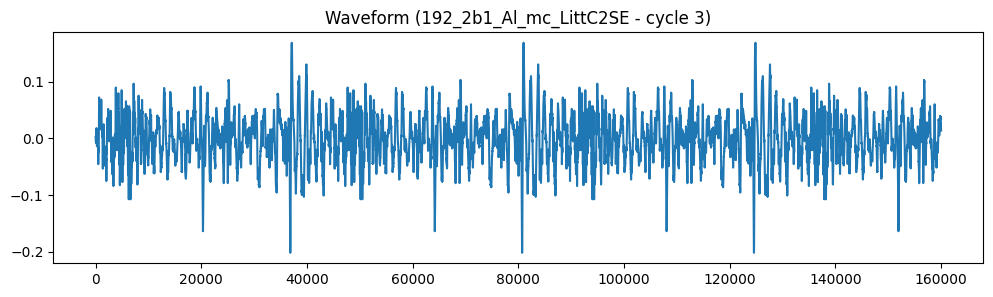

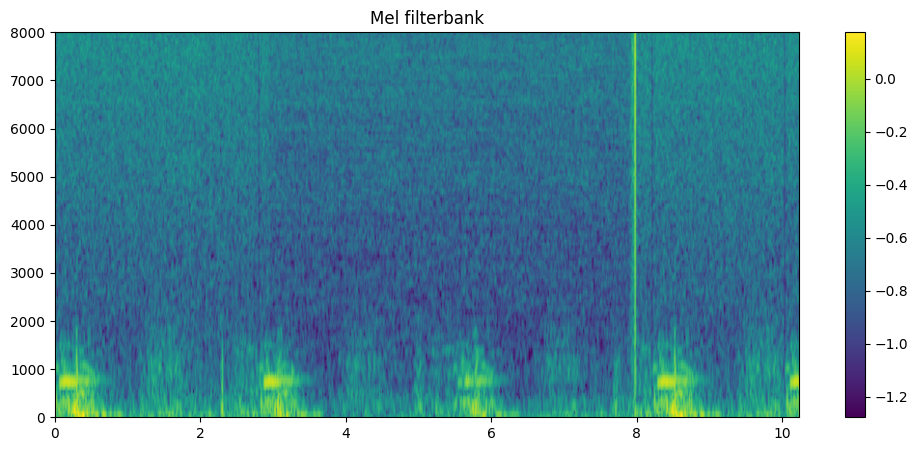

In [16]:
# --- Inspect one sample ---
idx = torch.randint(cfg.dataset.batch_size, (1,)).item()
print(f"Inspecting sample index {idx} in the batch")
print("Keys:", batch.keys())
print("Filename:", batch["filename"][idx])
print("Cycle index:", batch["cycle_index"][idx])
print("Label:", batch["label"][idx])
print("Duration:", batch["duration"][idx])
print("Start-End:", batch["start_time"][idx], "-", batch["end_time"][idx])
print("Crackle/Wheeze:", batch["label"][idx][0], batch["label"][idx][1])
# print(sample["aug_audio"].shape, sample["aug_fbank"].shape, sample["audio"].shape, sample["fbank"].shape)
print("Waveform shape:", batch["audio"][idx].shape)
print("Mel image shape:", batch["input_values"][idx].shape)
# print(f"Waveform augmented: {not tensors_equal(batch['audio'][idx].view(-1), batch['aug_audio'][idx].view(-1))}")
# print(f"Mel augmented: {not tensors_equal(batch['fbank'][idx].view(-1), batch['aug_fbank'][idx].view(-1))}")

# --- 4. Plot waveform ---
waveform = batch["audio"][idx].squeeze().numpy()
plt.figure(figsize=(12, 3))
plt.plot(waveform)
plt.title(f"Waveform ({batch['filename'][idx]} - cycle {batch['cycle_index'][idx]})")
plt.show()

# --- 5. Plot mel spectrogram ---
mel = batch["input_values"][idx].squeeze(0)  # [freq, time] for imshow
freq_axis = np.linspace(0, cfg.audio.sample_rate // 2, mel.shape[0])
time_axis = np.arange(mel.shape[1]) * cfg.audio.frame_shift / 1000  # in seconds
plt.figure(figsize=(12, 5))
plt.imshow(mel, origin="lower", aspect="auto", extent=[0, time_axis[-1], 0, freq_axis[-1]], cmap="viridis")
plt.title("Mel filterbank")
plt.colorbar()
plt.show()

ipd.Audio(waveform, rate=cfg.audio.sample_rate)  # listen to the sound

In [17]:
from ls.data.dataloaders import compute_and_cache_stats

mean, std = compute_and_cache_stats(
    train_loader.dataset, cache_file="train_stats.json", batch_size=cfg.dataset.batch_size,
    num_workers=cfg.dataset.num_workers
)
print(f"Dataset mean: {mean:.4f}, std: {std:.4f}")

[Stats] Computing dataset-wide mean/std...


100%|██████████| 259/259 [00:21<00:00, 11.79it/s]

[Stats] Cached mean=-0.3630, std=0.3738 to train_stats.json
Dataset mean: -0.3630, std: 0.3738


## Stratified Grouped KFold Dataloader

In [ ]:
from ls.data.dataloaders import build_train_val_kfold

In [ ]:
# Or: k-fold CV on train set
folds, test_loader = build_train_val_kfold(
    cfg.dataset, cfg.audio, n_splits=5, max_retries=50, seed=cfg.seed
)

In [ ]:
for i, (train_loader, val_loader) in enumerate(folds):
    # print(f"Training fold {i+1}")
    for batch in train_loader:
        # Process each batch
        print(batch["input_values"].shape, batch["label"].shape, batch["filename"])
        break